Calibration of the cloud mask total cloud fraction against the manual estimate of the cloud fraction.

In [24]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
dataloc = '../../ice_floe_validation_dataset/'
df = pd.read_csv(dataloc + '/data/validation_dataset/validation_dataset.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]

df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['seaice', 'landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, 'masie', imtype, '250m', 'tiff'])     

    elif imtype == 'cloudfraction_numeric':
        return '-'.join([cn, region, date, sat, imtype.replace('_numeric', '') + '.csv'])

# for plotting
region_order = ['greenland_sea', 'barents_kara_seas', 'laptev_sea', 'sea_of_okhostk',
                'east_siberian_sea', 'bering_chukchi_seas', 'beaufort_sea', 'hudson_bay', 'baffin_bay']

title_case = {'baffin_bay': 'Baffin Bay',
              'barents_kara_seas': 'Barents-Kara Seas',
              'beaufort_sea': 'Beaufort Sea',
              'bering_chukchi_seas': 'Bering-Chukchi Seas',
              'east_siberian_sea': 'East Siberian Sea',
              'greenland_sea': 'Greenland Sea',
              'hudson_bay': 'Hudson Bay',
              'laptev_sea': 'Laptev Sea',
              'sea_of_okhostk': 'Sea of Okhostk'}

# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cf_dataloc = dataloc + 'data/modis/cloudfraction_numeric/'


tc_images = {}
fc_images = {}
cf_images = {}
lb_images = {}
lf_images = {}


missing = []
for row, data in df.iterrows():
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cf_dataloc],
                                          ['truecolor', 'falsecolor', 'cloudfraction_numeric'],
                                          [tc_images, fc_images, cf_images]):
        try:
            if imtype == 'cloudfraction':                
                data_dict[row] = pd.read_csv("../data/cloudfraction_numeric/" + file, index_col=0) 
                data_dict[row].index = data_dict[row].index.astype(int)
                data_dict[row].columns = data_dict[row].columns.astype(int)
            else:
                with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                    data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype in ['seaice', 'landmask']: # masie images
                missing.append(fname(df.loc[row,:], imtype))

In [25]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction_manual').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)

# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        if case in fc_images:
            df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction_manual']).T

In [26]:
# Test/train split. Using random_state so that the test/train split is the same in each calibration test.
training_idx = df.sample(frac=2/3, random_state=97234).sort_index().index
df['training'] = False
df.loc[training_idx, 'training'] = True

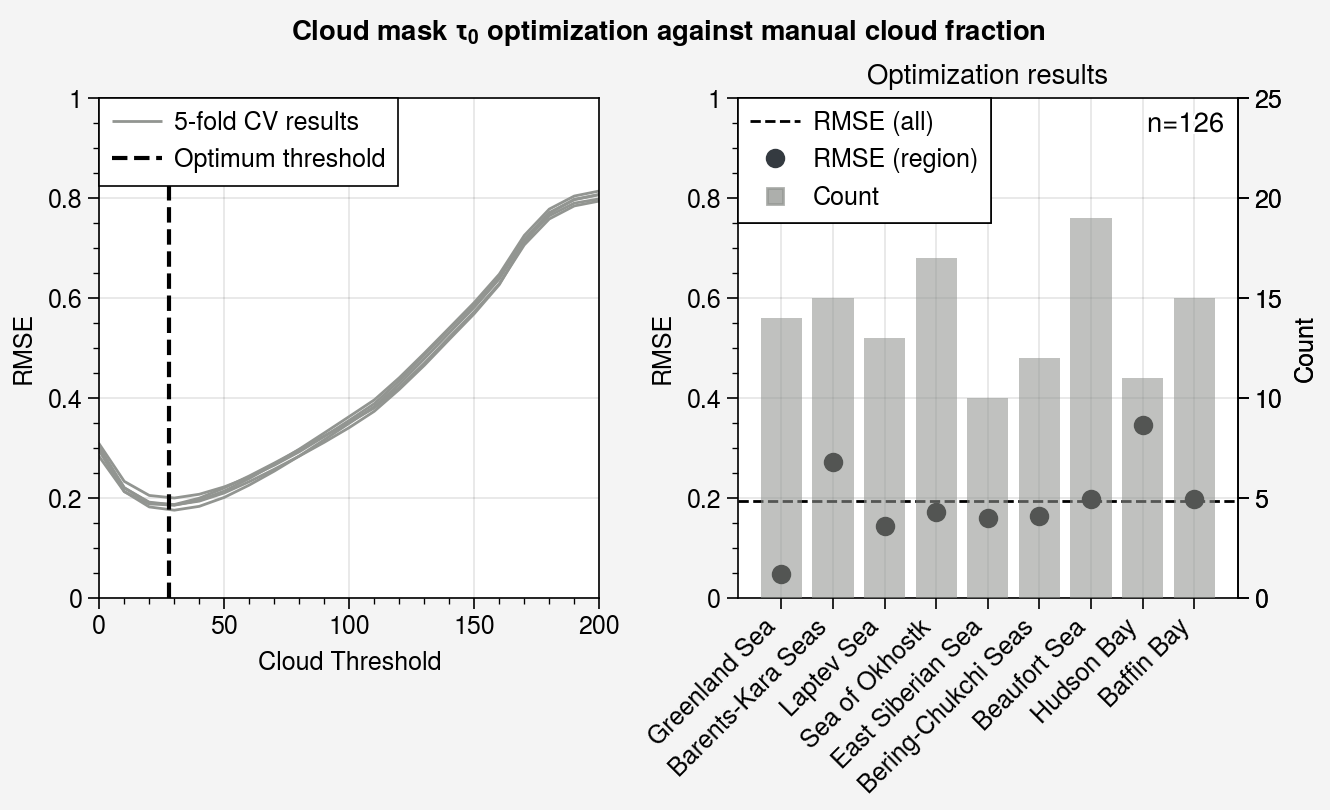

In [46]:
# Test version without splitting by regions to get syntax
fig, axs = pplt.subplots(ncols=2, share=False)
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []
ax = axs[0]
# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)
df_training = df_err.loc[df['training']].copy()
df_testing = df_err.loc[~df['training']].copy()
for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean(df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_manual']
            for case in test_cases if case in fc_images])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])

    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))


ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > kfold_results['TC']) - df.loc[case, 'cloud_fraction_manual']
        for case in df_testing.index if case in fc_images])
test_results = pd.DataFrame({'error': test_results}, index=[case for case in df_testing.index if case in fc_images])
test_results['region'] = df.loc[~df['training'], 'region']
test_rmse = np.sqrt(test_results.groupby('region').apply(lambda x: np.mean(x['error']**2), include_groups=False))
test_rmse = test_rmse[region_order]
test_rmse.index = [title_case[r] for r in test_rmse.index]

# ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1, alpha=1)

ax = axs[1]
ax.plot(test_rmse, marker='o', lw=0, zorder=2, color='k')

ax.axhline(tc_rmse, color='k', ls='--', lw=1)
ax2 = ax.twinx()
counts = test_results.groupby(df.loc[test_results.index, 'region']).count()
counts = counts.loc[region_order,:]
counts.index = [title_case[r] for r in counts.index]

ax2.bar(
    counts, zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
axs[0].format(ylim=(0, 1))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
axs.format(suptitle='Cloud mask $\\tau_0$ optimization against manual cloud fraction')

In [49]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
print('Cross validation results')
print(kfold_results.round(2))
print("\n")

tc, RMSE = kfold_results.mean(axis=0).round(2)
print('Training data')
print("Cloud threshold: ", int(tc))
print("RMSE (%): ", 100*RMSE)
print("\n")

# Error against the held-out data

df_testing = df_err.loc[~df['training']]
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction_manual']
        for case in df_testing.index if case in fc_images])
test_results = pd.Series(test_results, index=[case for case in df_testing.index if case in fc_images])
tc_rmse = np.sqrt(np.mean(test_results**2))
print('Comparison against test data')
print('RMSE (%):', np.round(tc_rmse*100, 1))

Cross validation results
     TC  RMSE
0  26.0  0.19
1  29.0  0.19
2  28.0  0.12
3  29.0  0.23
4  27.0  0.19


Training data
Cloud threshold:  27
RMSE (%):  18.0


Comparison against test data
RMSE (%): 20.2
